<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  int64  
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  int64  
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

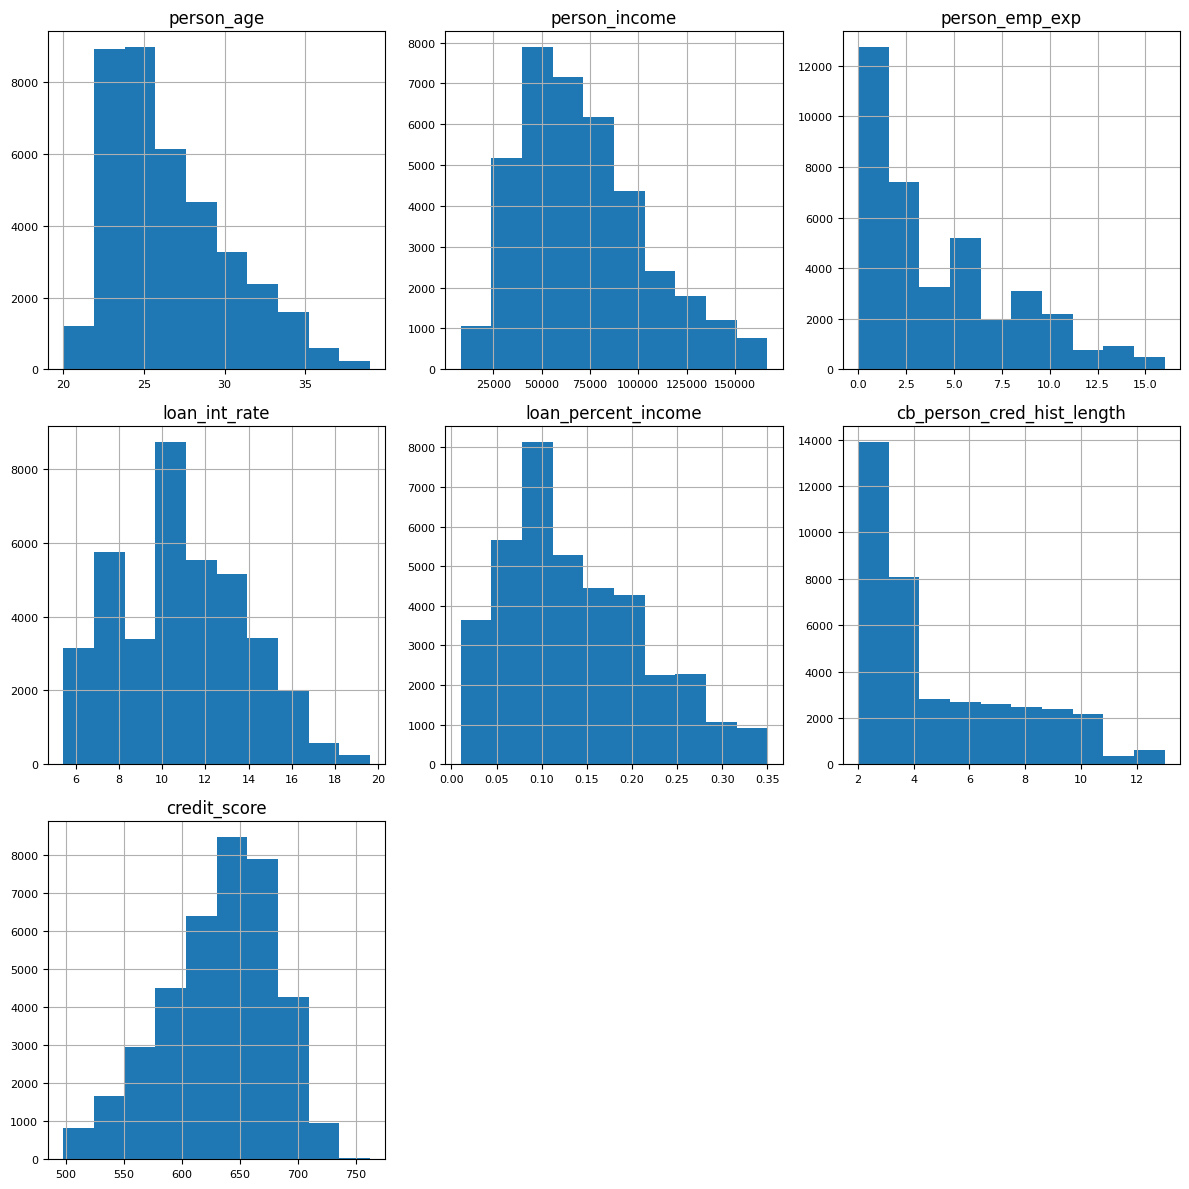

Variable person_income does not contain 0 or negative values. Applying log(x) transformation.
Variable loan_amnt does not contain 0 or negative values. Applying log(x) transformation.
Variable loan_percent_income does not contain 0 or negative values. Applying log(x) transformation.


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 34

# Load dataset
data = pd.read_csv("/Users/lucyyang/Desktop/ML/Dataset_ml.csv")

# Exploratory Data Analysis
print(data.info())
print(data.describe())

# Handle missing values if any
data = data.dropna()

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numerical_features = ['person_age', 
                      'person_income', 
                      'person_emp_exp', 
                      'loan_int_rate', 
                      'loan_percent_income', 
                      'cb_person_cred_hist_length', 
                      'credit_score']

# Apply outlier removal to numerical features
for feature in numerical_features:
    data = remove_outliers(data, feature)

# Plot histograms for numerical features after outlier removal
data[numerical_features].hist(sharex=False, sharey=False, xlabelsize=8, ylabelsize=8, figsize=(12, 12))
plt.tight_layout()
plt.show()

# Log transform the target variable
data['loan_amnt'] = np.log(data['loan_amnt'])
log_transform_vars = ['person_income', 'loan_amnt', 'loan_percent_income']

for var in log_transform_vars:
    if (data[var] <= 0).any():
        print(f"Variable {var} contains 0 or negative values.")
    else:
        print(f"Variable {var} does not contain 0 or negative values. Applying log(x) transformation.")
        data[f"{var}_log"] = np.log(data[var])  # log(x)
        data.drop(columns=log_transform_vars)

# Feature selection and preprocessing
numerical_features = ['person_age', 'person_income', 'person_emp_exp', 
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
categorical_features = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent']

# Define target variable
X = data[numerical_features + categorical_features]
y = data['loan_amnt']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Preprocessing pipeline for general models
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [36]:
# Ridge Regression with PCA
ridge_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', ridge_preprocessor),
    ('pca', PCA(n_components=5)),  # PCA for Ridge Regression only
    ('ridge', Ridge())
])

# Hyperparameter tuning for Ridge Regression
ridge_params = {'ridge__alpha': np.linspace(0.1, 100, 50)}
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Evaluate Ridge Regression
ridge_best_model = ridge_grid.best_estimator_
y_train_pred_ridge = ridge_best_model.predict(X_train)
y_pred_ridge = ridge_best_model.predict(X_test)
ridge_train_r2 = r2_score(y_train, y_train_pred_ridge)
ridge_test_r2 = r2_score(y_test, y_pred_ridge)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)

print("Ridge Regression Results:")
print(f"Best Alpha: {ridge_grid.best_params_['ridge__alpha']}")
print(f"Train R2: {ridge_train_r2:.4f}")
print(f"Test R2: {ridge_test_r2:.4f}")
print(f"MSE: {ridge_mse:.4f}")

Ridge Regression Results:
Best Alpha: 0.1
Train R2: 0.8114
Test R2: 0.8029
MSE: 0.0961


In [45]:
# Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=SEED))
])

rf_params = {'rf__n_estimators': [50, 100], 'rf__max_depth': [10, 20]}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Evaluate Random Forest
rf_best_model = rf_grid.best_estimator_
y_train_pred_rf = rf_best_model.predict(X_train)
y_pred_rf = rf_best_model.predict(X_test)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)

print("Random Forest Regression Results:")
print(f"Best Params: {rf_grid.best_params_}")
print(f"Train R2: {rf_train_r2:.4f}")
print(f"Test R2: {rf_test_r2:.4f}")
print(f"MSE: {rf_mse:.4f}")

Random Forest Regression Results:
Best Params: {'rf__max_depth': 20, 'rf__n_estimators': 100}
Train R2: 0.9996
Test R2: 0.9963
MSE: 0.0018


Epoch 1/50


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 10.4319 - mae: 2.1188 - mse: 10.4319 - val_loss: 0.1069 - val_mae: 0.2599 - val_mse: 0.1069
Epoch 2/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.9635 - mae: 0.7850 - mse: 0.9635 - val_loss: 0.0948 - val_mae: 0.2651 - val_mse: 0.0948
Epoch 3/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.8364 - mae: 0.7270 - mse: 0.8364 - val_loss: 0.0343 - val_mae: 0.1413 - val_mse: 0.0343
Epoch 4/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.7844 - mae: 0.7052 - mse: 0.7844 - val_loss: 0.0526 - val_mae: 0.1906 - val_mse: 0.0526
Epoch 5/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.7048 - mae: 0.6673 - mse: 0.7048 - val_loss: 0.0448 - val_mae: 0.1774 - val_mse: 0.0448
Epoch 6/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.6569 - mae: 0.6476 - mse: 0.6569 - val_loss: 0.0290 - val_mae: 0.1415 - val_mse: 0.0290
Epoch 7/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.6208 - mae: 0.6262 - mse: 0.6208 

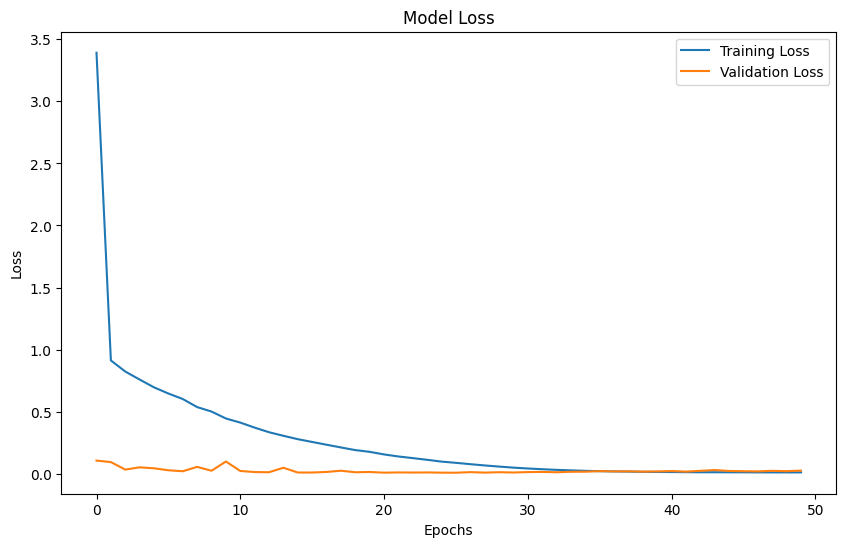

In [46]:
# ANN Model
X_preprocessed = preprocessor.fit_transform(X)
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X_preprocessed, y, test_size=0.2, random_state=SEED)

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')  # Regression output
    ])
    return model

input_dim = X_train_ann.shape[1]
ann_model = build_ann(input_dim)
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse', 'mae'])

history = ann_model.fit(
    X_train_ann, y_train_ann,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    shuffle=True
)

y_train_pred_ann = ann_model.predict(X_train_ann)
y_pred_ann = ann_model.predict(X_test_ann)
ann_train_r2 = r2_score(y_train_ann, y_train_pred_ann)
ann_test_r2 = r2_score(y_test_ann, y_pred_ann)
ann_mse = mean_squared_error(y_test_ann, y_pred_ann)

print("ANN Regression Results:")
print(f"Train R2: {ann_train_r2:.4f}")
print(f"Test R2: {ann_test_r2:.4f}")
print(f"MSE: {ann_mse:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model Performance Comparison:
              Model  Train R2   Test R2       MSE
0  Ridge Regression  0.843152  0.835244  0.080316
1     Random Forest  0.999576  0.996303  0.001802
2               ANN  0.949672  0.948886  0.024917


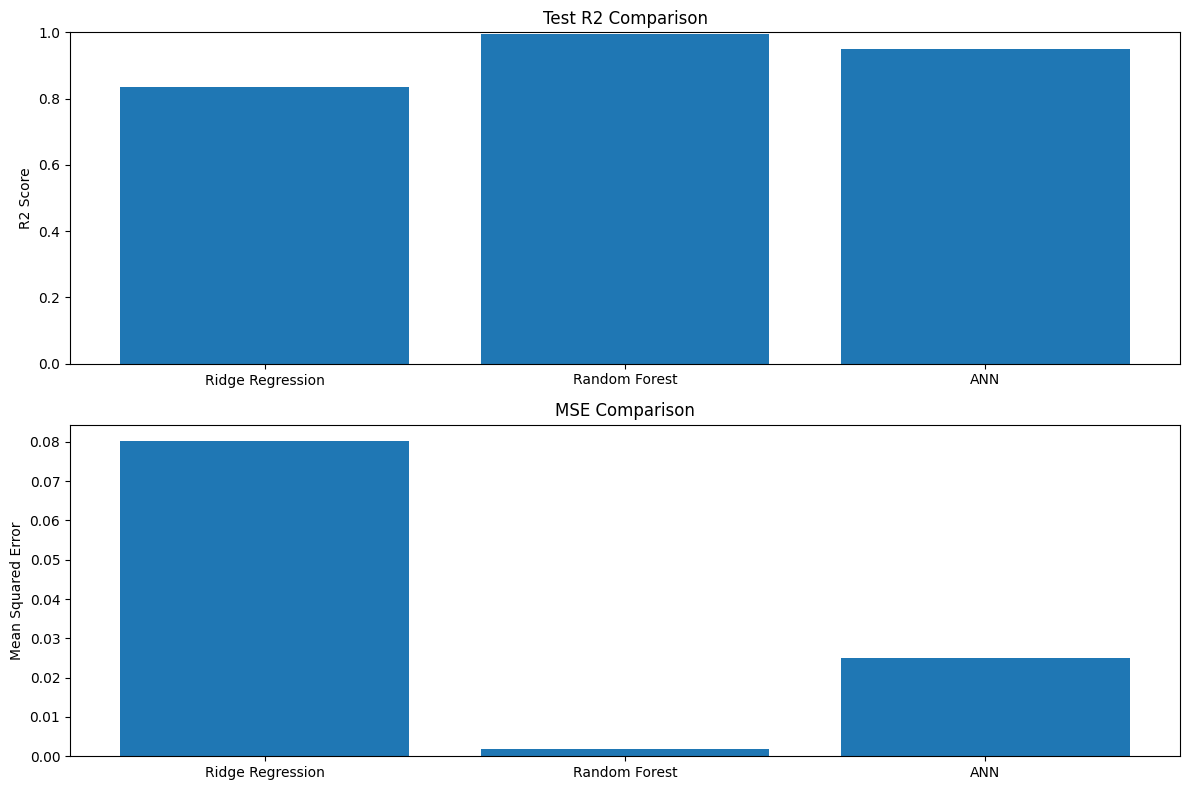

In [47]:
# Performance comparison

performance_data = {
    'Model': ['Ridge Regression', 'Random Forest', 'ANN'],
    'Train R2': [ridge_train_r2, rf_train_r2, ann_train_r2],
    'Test R2': [ridge_test_r2, rf_test_r2, ann_test_r2],
    'MSE': [ridge_mse, rf_mse, ann_mse]
}

performance_df = pd.DataFrame(performance_data)

print("\nModel Performance Comparison:")
print(performance_df)

# Visualize the comparison
plt.figure(figsize=(12, 8))

# Test R2 comparison
plt.subplot(2, 1, 1)
plt.bar(performance_df['Model'], performance_df['Test R2'])
plt.title('Test R2 Comparison')
plt.ylabel('R2 Score')
plt.ylim(0, 1)

# MSE comparison
plt.subplot(2, 1, 2)
plt.bar(performance_df['Model'], performance_df['MSE'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()